# Visualizing and Animating positions

In [1]:
## Load in some dependencies
library(dplyr); library(data.table); library(ggplot2); library(ggforce)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [2]:
nhwl_df <- read.csv("../input/nhwldata/Rotman MMA Summer Datathon NWHL.csv")
head(nhwl_df)

,game_date,Home.Team,Away.Team,Period,Clock,Home.Team.Skaters,Away.Team.Skaters,Home.Team.Goals,Away.Team.Goals,Team,⋯,Event,X.Coordinate,Y.Coordinate,Detail.1,Detail.2,Detail.3,Detail.4,Player.2,X.Coordinate.2,Y.Coordinate.2
,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,⋯,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>
1,2021-01-23,Minnesota Whitecaps,Boston Pride,1,20:00,5,5,0,0,Boston Pride,⋯,Faceoff Win,100,43,Backhand,,,,Stephanie Anderson,NA,NA
2,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:58,5,5,0,0,Boston Pride,⋯,Puck Recovery,107,40,,,,,,NA,NA
3,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:57,5,5,0,0,Boston Pride,⋯,Zone Entry,125,28,Carried,,,,Maddie Rowe,NA,NA
4,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:55,5,5,0,0,Boston Pride,⋯,Shot,131,28,Snapshot,On Net,t,f,,NA,NA
5,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:53,5,5,0,0,Boston Pride,⋯,Faceoff Win,169,21,Backhand,,,,Stephanie Anderson,NA,NA
6,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:52,5,5,0,0,Boston Pride,⋯,Puck Recovery,159,26,,,,,,NA,NA


In [3]:
nhwl_plays_df <- nhwl_df %>%
  filter(Event %in% c("Play", "Incomplete Play"), Detail.1 == "Direct", X.Coordinate >= 125, X.Coordinate.2 >= 125) %>%
  mutate(start_x = Y.Coordinate,
         start_y = X.Coordinate,
         end_x = Y.Coordinate.2,
         end_y = X.Coordinate.2,
         
         delta_x = end_x - start_x,
         delta_y = end_y - start_y,
         
         is_complete = ifelse(Event == "Play", 1, 0))

head(nhwl_plays_df,10)

,game_date,Home.Team,Away.Team,Period,Clock,Home.Team.Skaters,Away.Team.Skaters,Home.Team.Goals,Away.Team.Goals,Team,⋯,Player.2,X.Coordinate.2,Y.Coordinate.2,start_x,start_y,end_x,end_y,delta_x,delta_y,is_complete
,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,⋯,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:43,5,5,0,0,Minnesota Whitecaps,⋯,Haley Mack,196,33,20,193,33,196,13,3,1
2,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:08,5,5,0,0,Minnesota Whitecaps,⋯,Nina Rodgers,161,14,10,168,14,161,4,-7,1
3,2021-01-23,Minnesota Whitecaps,Boston Pride,1,18:51,5,5,0,0,Boston Pride,⋯,McKenna Brand,175,47,65,195,47,175,-18,-20,0
4,2021-01-23,Minnesota Whitecaps,Boston Pride,1,18:36,5,5,0,0,Boston Pride,⋯,McKenna Brand,168,74,52,135,74,168,22,33,1
5,2021-01-23,Minnesota Whitecaps,Boston Pride,1,18:29,5,5,0,0,Boston Pride,⋯,Lauren Kelly,165,22,82,174,22,165,-60,-9,0
6,2021-01-23,Minnesota Whitecaps,Boston Pride,1,16:50,5,5,0,0,Minnesota Whitecaps,⋯,Haylea Schmid,180,48,53,199,48,180,-5,-19,1
7,2021-01-23,Minnesota Whitecaps,Boston Pride,1,16:40,5,5,0,0,Boston Pride,⋯,Samantha Davis,180,42,64,175,42,180,-22,5,0
8,2021-01-23,Minnesota Whitecaps,Boston Pride,1,16:38,5,5,0,0,Boston Pride,⋯,Taylor Turnquist,143,81,63,174,81,143,18,-31,1
9,2021-01-23,Minnesota Whitecaps,Boston Pride,1,16:32,5,5,0,0,Boston Pride,⋯,Samantha Davis,198,46,61,198,46,198,-15,0,1


In [4]:
# nhwl_plays_df <- nhwl_plays_df[nhwl_plays_df$Player == 'Taylor Woods', ]
# nhwl_plays_df <- nhwl_plays_df[nhwl_plays_df$Period == 2, ]
# nhwl_plays_df <- nhwl_plays_df[nhwl_plays_df$game_date == '2021-01-31', ]
# nhwl_plays_df

## Clustering

In [5]:
cluster_fit <- kmeans(nhwl_plays_df %>% select(start_x: delta_y), centers = 50)
nhwl_plays_df$cluster <- cluster_fit$cluster

In [6]:
cluster_summary <- nhwl_plays_df %>%
  group_by(cluster) %>%
  summarise(total_passes = n(),
            comp_rate = mean(is_complete))

risky_passes <- (cluster_summary %>%
                   arrange(comp_rate) %>%
                   .$cluster)[1:3]

safe_passes <- (cluster_summary %>%
                   arrange(desc(comp_rate)) %>%
                   .$cluster)[1:3]

## Plotting static clusters

In [7]:
# Plot clusters
risky_dat <- bind_rows(nhwl_plays_df %>%
                         filter(cluster == risky_passes[1]) %>%
                         sample_n(20, replace = FALSE),
                       nhwl_plays_df %>%
                         filter(cluster == risky_passes[2]) %>%
                         sample_n(20, replace = FALSE),
                       nhwl_plays_df %>%
                         filter(cluster == risky_passes[3]) %>%
                         sample_n(20, replace = FALSE))


risky_passes_plot <- ggplot(data = risky_dat, aes(end_x, end_y, col = factor(cluster))) + 
  geom_segment(aes(x = start_x, y = start_y, xend = end_x, yend = end_y),
               arrow = arrow(length = unit(0.3, "cm"))) +
  geom_circle(data = data.frame(x0 = 42.5, y0 = 100, r = 15), aes(x0 = x0, y0 = y0, r = r), 
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 20.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 64.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_point(inherit.aes = FALSE, aes(x = 42.5, y = 100),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 120),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 120),
             col = "gray50", size = 1) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 0, y = 189, xend = 85, yend = 189)) +
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 45.5, yend = 192.5)) + 
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 39.5, yend = 189)) +  
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 45.5, y = 192.5, xend = 45.5, yend = 189)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 33.5, y = 189, xend = 28.5, yend = 200)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 51.5, y = 189, xend = 56.5, yend = 200)) +
  geom_hline(col = "gray50", yintercept = 125, lwd = 0.5) +
  scale_x_continuous(expand = c(0, 0)) + scale_y_continuous(expand = c(0,0)) +
  ylab("OFFENSIVE ZONE") +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y = element_text(size=12),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        panel.border = element_rect(colour = "gray50", fill=NA, size=0.2)) +
  coord_fixed(xlim = c(0,85), ylim = c(100,200)) +
  annotate("label", x = 42.5, y = 112.5, label = "Risky Passes", size = 5.5, fill = "mistyrose")


safe_dat <- bind_rows(nhwl_plays_df %>%
                        filter(cluster == safe_passes[1]) %>%
                        sample_n(20, replace = FALSE),
                      nhwl_plays_df %>%
                        filter(cluster == safe_passes[2]) %>%
                        sample_n(20, replace = FALSE),
                      nhwl_plays_df %>%
                        filter(cluster == safe_passes[3]) %>%
                        sample_n(20, replace = FALSE))


safe_passes_plot <- ggplot(data = safe_dat, aes(end_x, end_y, col = factor(cluster))) + 
  geom_segment(aes(x = start_x, y = start_y, xend = end_x, yend = end_y),
               arrow = arrow(length = unit(0.3, "cm"))) +
  geom_circle(data = data.frame(x0 = 42.5, y0 = 100, r = 15), aes(x0 = x0, y0 = y0, r = r), 
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 20.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 64.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_point(inherit.aes = FALSE, aes(x = 42.5, y = 100),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 120),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 120),
             col = "gray50", size = 1) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 0, y = 189, xend = 85, yend = 189)) +
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 45.5, yend = 192.5)) + 
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 39.5, yend = 189)) +  
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 45.5, y = 192.5, xend = 45.5, yend = 189)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 33.5, y = 189, xend = 28.5, yend = 200)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 51.5, y = 189, xend = 56.5, yend = 200)) +
  geom_hline(col = "gray50", yintercept = 125, lwd = 0.5) +
  scale_x_continuous(expand = c(0, 0)) + scale_y_continuous(expand = c(0,0)) +
  ylab("OFFENSIVE ZONE") +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y = element_text(size=12),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        panel.border = element_rect(colour = "gray50", fill=NA, size=0.2)) +
  coord_fixed(xlim = c(0,85), ylim = c(100,200)) +
  annotate("label", x = 42.5, y = 112.5, label = "Safe Passes", size = 5.5, fill = "azure")

Risky passes: 

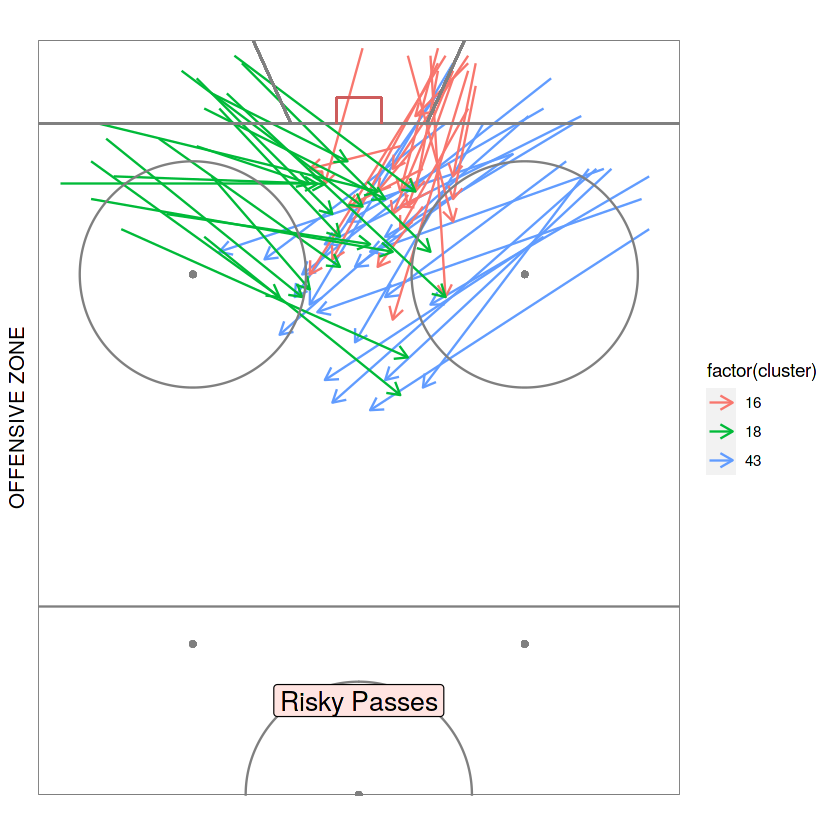

In [8]:
cat("Risky passes: ")
print(risky_passes_plot)

Safe passes: 

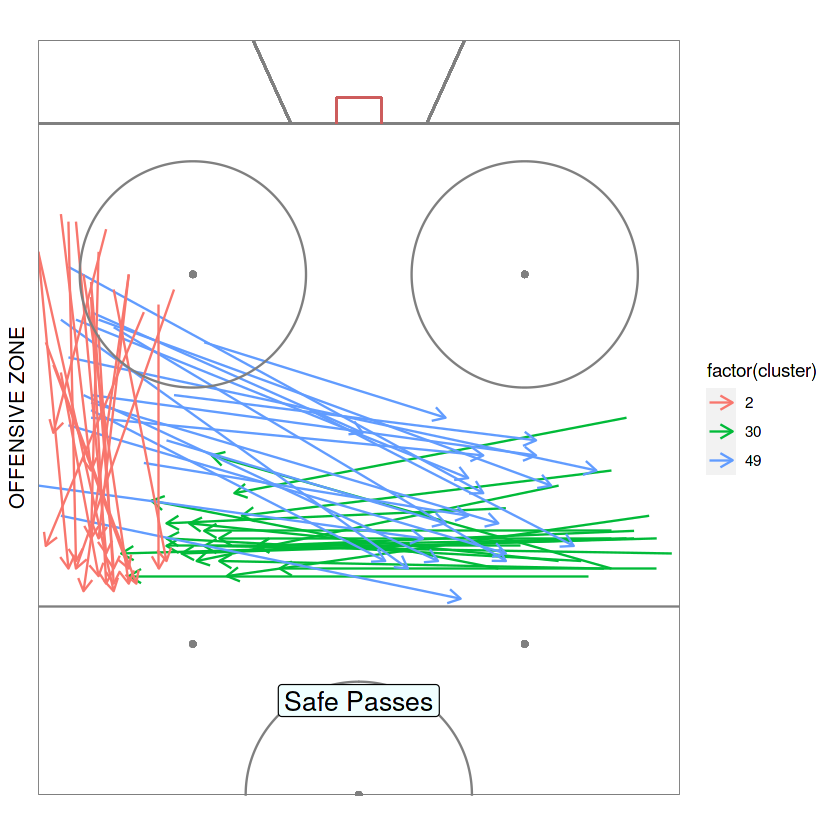

In [9]:
cat("Safe passes: ")
print(safe_passes_plot)

As we can see risky passes are close to the goal while the safe passes are away from the goal

In [10]:
library(gganimate)

anim <- risky_passes_plot + 
                      transition_states(Clock)

anim

## Visualizing the Passes of Taylor woods

In [17]:
passes_players_df <- nhwl_plays_df[nhwl_plays_df$Player == 'Taylor Woods',]
head(passes_players_df)

,game_date,Home.Team,Away.Team,Period,Clock,Home.Team.Skaters,Away.Team.Skaters,Home.Team.Goals,Away.Team.Goals,Team,⋯,X.Coordinate.2,Y.Coordinate.2,start_x,start_y,end_x,end_y,delta_x,delta_y,is_complete,cluster
,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>
394,2021-01-23,Metropolitan Riveters,Toronto Six,1,10:44,4,5,1,0,Toronto Six,⋯,162,10,27,131,10,162,-17,31,1,17
422,2021-01-23,Metropolitan Riveters,Toronto Six,1,4:15,4,5,1,0,Toronto Six,⋯,153,16,58,134,16,153,-42,19,1,31
424,2021-01-23,Metropolitan Riveters,Toronto Six,1,4:12,4,5,1,0,Toronto Six,⋯,149,63,40,129,63,149,23,20,1,34
489,2021-01-23,Metropolitan Riveters,Toronto Six,2,2:29,5,5,2,0,Toronto Six,⋯,129,18,60,159,18,129,-42,-30,1,50
933,2021-01-24,Toronto Six,Minnesota Whitecaps,1,12:12,5,4,0,0,Toronto Six,⋯,135,14,47,135,14,135,-33,0,1,5
951,2021-01-24,Toronto Six,Minnesota Whitecaps,1,8:34,5,4,2,0,Toronto Six,⋯,126,65,33,130,65,126,32,-4,1,48


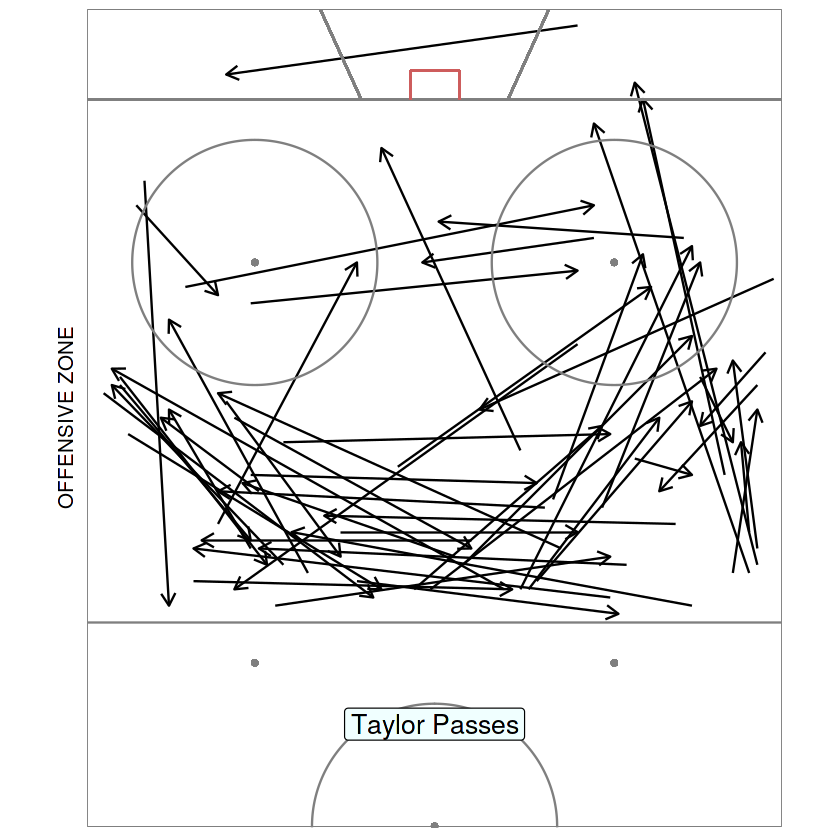

In [21]:
taylor_passes_plot <- ggplot(data = passes_players_df, aes(end_x, end_y)) + 
  geom_segment(aes(x = start_x, y = start_y, xend = end_x, yend = end_y),
               arrow = arrow(length = unit(0.3, "cm"))) +
  geom_circle(data = data.frame(x0 = 42.5, y0 = 100, r = 15), aes(x0 = x0, y0 = y0, r = r), 
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 20.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 64.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_point(inherit.aes = FALSE, aes(x = 42.5, y = 100),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 120),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 120),
             col = "gray50", size = 1) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 0, y = 189, xend = 85, yend = 189)) +
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 45.5, yend = 192.5)) + 
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 39.5, yend = 189)) +  
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 45.5, y = 192.5, xend = 45.5, yend = 189)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 33.5, y = 189, xend = 28.5, yend = 200)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 51.5, y = 189, xend = 56.5, yend = 200)) +
  geom_hline(col = "gray50", yintercept = 125, lwd = 0.5) +
  scale_x_continuous(expand = c(0, 0)) + scale_y_continuous(expand = c(0,0)) +
  ylab("OFFENSIVE ZONE") +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y = element_text(size=12),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        panel.border = element_rect(colour = "gray50", fill=NA, size=0.2)) +
  coord_fixed(xlim = c(0,85), ylim = c(100,200)) +
  annotate("label", x = 42.5, y = 112.5, label = "Taylor Passes", size = 5.5, fill = "azure")

taylor_passes_plot

In [25]:
library(gganimate)

anim <- taylor_passes_plot + transition_states(end_x)

anim

<img src="data:image/gif;base64,R0lGODlh4AHgAfYAAAICAgsMDA8QEBMTExcYGBscHB4gICMkJCcpKSssLC8yMjIzMzY5OTo7
Oz5CQkNDQ0ZKSktMTE5TU1RUVFVaWlxdXVxiYmRkZGZsbG1tbW51dXZ2dnJ5eX19faN2ds1c
XMVjY89iYtBjY9Z7e3uDg4SEhIKKiomJiY2Wlo+YmJSUlJOcnJubm5egoJqkpJ6oqKKioqOt
raurq6exsaq1ta65uba2trK9vbu7u+eurui0tLbBwbrGxr3JycPDw8DMzMvLy8bS0sjV1c3a
2tTU1NDd3d3d3fLU1NXi4tnn59zq6uTk5OHv7+vr6/nq6uTy8uj39+38/PT09PD//////wAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAACH5BAQKAAAAIf8LTkVUU0NBUEUyLjADAQAAACwAAAAA4AHg
AQAH/oBUgoOEhYaHiImKi4yNjo+QkZKTlJWWl5iZmpucnZ6foKGio6SlpqeoqaqrrK2ur7Cx
srO0tba3uLm6u7y9vr/AwcLDxMWjTUvJysvMzc7P0NHS09TV1tMsRNfb3N3e39syOODk5ebn
0kbGjUvrvScs7rdNJeryue33iPn6t0QlUvrJgnFC4C1+BgUhTCirhAyGraSUAAJx1kKDFyu2
wlFCoyoZHT3CytiPpMhUJWycNJVypSuT92C6JAVypiiONlnJdLcz5yeJFH12cig0VU9jR4tu
IqhU07+ATUslJTY1qqUmHYhYtQRvK6mqwsB6lcRCxVhJRkqIPeto7S+3/mwZpYXbVIXZuJ/o
8tKLF1HXvoro2QO8ia8uw4QHEekANXEhpo41IcY12THRyIOAYs5U2VZnwjZCbq65GdNnWqcB
t9y8urSl1LJg4yUdGUcH16Y1DsZdaSLmy7wp7U4oGy/kxE+DVyr+ijlbeloTn4ChfLlG52zt
Jp5bnRJ2nd29d2hCWHt4Sd9XpR/7Fy/08+ivw5eU3HjB+ZDWG8UfCTjbDkHxx458AjqCU1y0
FbiIfqgw6FVrY0GoYCIOmlKhVaGxleGEjFz4FYeMaBbhQyAq4uEoJzZ1nFVAAFSiiQS+iMh7
W00nI4Ux3mhIWVtxp6MhKYYSpFI+NsXjj0Dm/ojkIO2B4sSTUEYp5ZRUioLVcEsOmdeShgDB
WCgjfCDmmGSWaaaZIRwRyopcUqGlJ28W5V8nIuSgSQg6gCJimwop2eaBn9R5Z56fJMhnnJwg
KpSEmwiaCZ6gMMqlopLxWYihjdr5KKGdAGqpm362uScnjmICqSdz8omlQJT6xKYmpV5yKict
NvZpq5is2uaVnsRqyaybqBDPp4PgeomxNplHqqamcqpJWuQR22dFyM4ELZ3MyupsJspKW613
0hLSZCa+VgIsJjSG++0k665UH6zZ/rrtJa/eGuqnqVpSLiXnWjKqt/da6ikm+07SbyWYEttu
JAuvJCklBUtyMCUP/lva8CMXi5QwxPFWIsK8lAysrkYynGCyySWcrPLKLLOccsswt/xyzDTX
bPPNOOcc88wndMDzzT+fDIIHNpfwctBCEw0z0jKfYLTKTOMctc5UVw201VBjnXLQGgFhw9dg
hy322GSXbfbZaKet9tpst+3223CTjUPcdNdt991456232SRClHG4gFdKbeCE+/R3h4Un7tLh
CyruuEeMw/j45MQFTPnlw0SOI+acr6P5Pp2HTpXlopfuGemmpx6Lrvp8rjrgrif5+uy1xF6I
7bQfinruvH84eO/Aq7d78MQXNnzxyL92fPLMM7x889Aj/nv01Cs/ffXYO18R6wkhYwQR/kAA
4cP4QBChDe6RSbHE9+GP70P5RBjRhK3PhwWRFET4IAMLPZcgLAwykMHXZAADGJSlfywQIBGi
1TspGMEHNiiLz4SVQAEGkIAwUIHT/AcDG2jDb/XbxRL05zQW2MAH8oOEA71GkBKwAAfco1wT
gCADFXRABTJA4RLopwj1AQEHLTQhEXiIlBDaAn8lO4EMgDCZJhDBBiooAQx8wEDKGcEGToMB
EznhwAi6cBzyQN+0ikEEGLjQB8WRAg395wMihosIIFGBDdL4xBOoAAdVtN/1gLGEkrEACG4c
BRylGJ1wNQGLKqDiKowAkj+Obo+9IIIGbZDHVUjBBxps46eM/mDGOcaCCCxISSVFaERW+AAe
AbJIJ0f5Ikkm0haHdAgrD1LKVAABHjF8hRRCY4NAFsiVqTxiaGQwS1rk0nO8IAIufRFLH7zI
CGUpJC946ctYiBFUuWgC/6TpiyUQhJv4kULJgtkLcZ7Amfio5SiwiE5iGGE6xQxOi3pZjCWU
BVHXjNMSVACDePoiNO0MjzZVwLh50hKSsMAiOJHCz2pGpkU46EcTMqilfNKiCcLy5zBCc0zA
UDQhtwzoSHQzC2VGFCLvVAlulqBEauHQIurcxCk7agwpsAAGDj3LP8iZkAxq1HcghEUNfyqP
oWIGBye4JiGQ6iGLusKmOJ0JUx1j/lSX/GOhDYqpv+Tok3/QVCgFzClGTsDTU3x1GGfl4glU
6pO0pHUlUC0KS0WaVYSWogknOGlR0oJVI/VNKHilq4W0Kgkp3NEqbj3LTa2C17KiiLAqNKFX
ihSVAnoFr30VEmQfkUCdnoCoGongWZZQj/3YNRSiZQsmxVqR1bLlWqdwqilcG5fUCkWZoJ3J
LVmbm9N6ArZ4kaxPBAMYAsZ2sz08QWatIgXl+uSVhHnhYH3LCeESBrgrMW5i8PrW+FBXEzgY
lmN8IN6TKJO3SjkvUBlSHNLm1kh69YhEuisUG/wVFLINhQoc654SvJcYHSxNc5fb26CGgry4
Ca9IlImb/neiV3sG/gQ9/muV/XrkBPRtigBFkV9PwCC+pSHtg4FhA+rwRiKp6TAn3lmdDTOE
HiP2CoLxi1xCWFg5EqEwL1ysHBUQGFzfpQQQ7lId+xLnBDEey5BBkeFenMbH4cmxQT58HijD
qcZUAEJ5q4OD+/LkPuGR5JaCLAkrR9m//eBxeDB8ZTJDgsXz+Zo+YDwfLbc5wprQIn7oLA85
4yepnVDxJfg8nyneA834mVugkato/hiByMYApYAIzRnkAlpAlzaGngW0acHh+RKPVpCfi0Hp
Om/5WCTdhDgURNp16G9CLvI0ezmB6AKpoMmvyMaEOl3gWT8L0gIatTAkkmTH/kha1pXThLAF
xNJiAMHECiI2sjESLFwnptbBWCKIdF1pNy+CHiXS9jA+C6JG9zrZmChjiV4dFjBPKNSZsPZh
lA3iAjVbGDR8UaxR7W1FsEDe1y42K3L4olt3+9OTkHaJuA0Mg5fIBvVml1bv/XDB7mLfHHr2
wX19CXW/SON8dDeH9rlxdFsC4jKC9y88XiIp3Obc1MaEuFsuGl+Yu0Tk5jfCywxwy+h4FSe8
0b9hLhBr57zg32J4uPnbFq2+XEYw+PEsCHojlOuc45WQiI5m3gtsl5ut1un3ISj+oqD/AuMg
yvfVTe4dYINo2brQ+o1YHnaU5urUHILgL+SecrxH/qLnB7XEsYNhWOcKQ+/MrDkw+GfxXUCT
6CVJN7QX7zOR+4LdvcDrRn32dGCovO5YpwTdf8GCDnTA8r1Qe+ZRP80S+Ezgi/R7fmL6+GFr
kOm4QPzqicE/sP+i9tbb+ZtlXyDd8wLcNwI+6NnOLrdz6Oa86HyJRi9xsQOJ9aJu/C2+JCPV
Lz/m/lI8iLjOC7Q/3/fVFz4kxM8hpfOC6jIye/BDT7Gfu8bhvoj6jXgNZPU/Av8l4nW7QHAy
MnRrB36WQH4TwneXh34TcnTfxy